### 载入工具包

In [2]:
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None  # 消除警告，比如说提示版本升级之类的

pd.set_option('display.max_columns', 60)  # 设置最大显示列为60

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 24  # 设置字体大小

from IPython.core.pylabtools import figsize  # 设置画图大小

import seaborn as sns  # 画图工具
sns.set(font_scale=2)

# 输入缺失值和缩放值
from sklearn.preprocessing import Imputer, MinMaxScaler

# 机器学习模型
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# 超参数调整
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:   (2839, 64)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


In [4]:
train_features.head()

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 缺失值填充

利用sklearn的 Imputer object来进行缺失值填充，测试集则使用数据集中的结果进行填充，尽可能的不要利用测试集的数据对测试集加工，因为一开始我们也是不知道的，可参考[Data Leagage](https://www.kaggle.com/dansbecker/data-leakage)。

In [6]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy = 'median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [7]:
print('Missing values in training features:', np.sum(np.isnan(X)))
print('Missing values in testing features:',np.sum(np.isnan(X_test)))

Missing values in training features: 0
Missing values in testing features: 0


In [8]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


## 特征标准化与归一化

In [9]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both training data and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [10]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

### 选择的机器学习算法（回归问题）
    1. Linear Regression
    2. Support Vector Machine Regression
    3. Random Forest Regression
    4. Gradient Boosting Regression
    5. K-Nearest Neighbors Regression

这里先使用默认参数，后续再调参

In [12]:
# Function to calculation mean absolute error
def mae (y_true,y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X,y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test,model_pred)
    
    # Return the performance metric
    return model_mae

In [13]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f'% lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


In [14]:
svm = SVR(C=1000,gamma =0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.9337


In [15]:
random_forest = RandomForestRegressor(random_state = 60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Performance on the test set: MAE = 10.0073


In [16]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0144


In [17]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0131


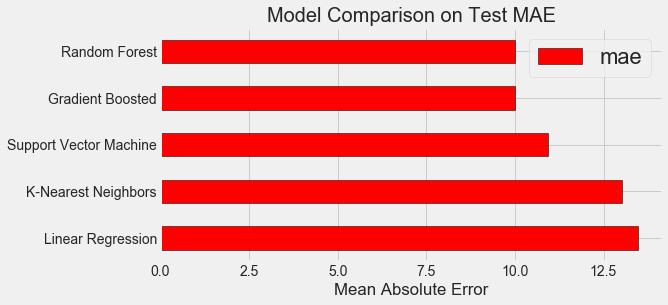

In [18]:
plt.style.use('fivethirtyeight')
figsize(8, 4)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model':['Linear Regression',
                                          'Support Vector Machine',
                                          'Random Forest',
                                          'Gradient Boosted',
                                          'K-Nearest Neighbors'],
                                'mae':[lr_mae,
                                       svm_mae,
                                       random_forest_mae, 
                                       gradient_boosted_mae, 
                                       knn_mae]})
# Horizontal bar chart of test mae
model_comparison.sort_values('mae',ascending = False).plot(x = 'model',
                                                           y = 'mae',
                                                           kind = 'barh',
                                                           color = 'red', 
                                                           edgecolor = 'black')
# Plot formatting
plt.ylabel('');plt.yticks(size = 14);plt.xlabel('Mean Absolute Error');plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

集成算法的效果更好，这里由于参数只使用默认的，对SVM等这种参数影响较大的模型不太公平。

### 调参

### Cross Validation
<img src="data/kfold_cv.png" width="70%">

In [20]:
# 设置相关参数
# 要优化的损失函数
loss = ['ls','lad','huber']

# 梯度增强过程中使用的树的数量
n_estimators = [100,500, 900, 1100,1500]

#  树的最大深度
max_depth = [2,3,5,10,15]

# 每片叶子的最小样本数
min_samples_leaf = [1,2,4,6,8]

# 拆分节点的最小样本数
min_samples_split = [2, 4, 6, 10]

# 进行拆分时要考虑的最大特征数
max_features = ['auto', 'sqrt', 'log2', None]

# 定义要进行搜索的超参数网格
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}  

#### 随机搜索

In [21]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [22]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.8min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [23]:
# 获取所有cv结果并按测试性能排序
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,10.512508,0.161444,0.021770,0.001280,500,6,6,None,5,lad,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.924621,-8.775078,-9.325044,-9.037550,-9.015523,0.201467,1,-6.934705,-6.837958,-6.869084,-6.840749,-6.870624,0.038950
3,11.610687,0.557825,0.034470,0.010364,500,6,8,None,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.872382,-8.903982,-9.317120,-9.075047,-9.042086,0.176489,2,-4.384343,-4.326121,-4.823009,-4.229809,-4.440820,0.227453
9,9.308119,0.115381,0.019372,0.002762,500,4,2,auto,3,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.062297,-9.042221,-9.439618,-9.153004,-9.174248,0.158764,3,-6.955777,-7.088986,-6.913108,-6.940327,-6.974550,0.067813
0,2.768650,0.022904,0.010735,0.006010,100,2,6,auto,5,ls,"{'n_estimators': 100, 'min_samples_split': 2, ...",-9.100775,-9.026372,-9.457063,-9.201235,-9.196321,0.162799,4,-7.302003,-7.312645,-7.173397,-7.386171,-7.293554,0.076569
7,5.052495,0.146989,0.016706,0.003104,500,4,6,auto,3,ls,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.147703,-9.199053,-9.698781,-9.358627,-9.350987,0.215296,5,-7.089709,-7.103749,-7.021418,-7.080088,-7.073741,0.031358
19,12.648192,0.497953,0.025433,0.002286,1100,6,2,auto,3,lad,"{'n_estimators': 1100, 'min_samples_split': 6,...",-9.350800,-9.382812,-9.475236,-9.291753,-9.375148,0.066368,6,-8.513004,-8.658903,-7.820534,-8.017995,-8.252609,0.344461
10,62.647066,2.078449,0.127230,0.011548,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-9.274382,-9.242743,-9.530568,-9.475944,-9.380872,0.124366,7,-0.409811,-0.459465,-0.393491,-0.370483,-0.408312,0.032671
2,39.648134,1.619497,0.063250,0.002862,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.415934,-9.291198,-9.575363,-9.429866,-9.428068,0.100721,8,-0.205702,-0.193613,-0.164415,-0.141062,-0.176198,0.025235
16,17.596702,0.263915,0.041574,0.001576,1500,4,6,None,3,ls,"{'n_estimators': 1500, 'min_samples_split': 4,...",-9.248892,-9.316306,-9.798843,-9.427920,-9.447940,0.212403,9,-4.821677,-4.876202,-4.776650,-4.729506,-4.801009,0.054284
21,3.955678,0.036891,0.033909,0.007227,500,6,4,log2,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.365194,-9.286988,-9.751767,-9.409179,-9.453243,0.177788,10,-5.733003,-5.742441,-5.571781,-5.666476,-5.678425,0.068177


In [24]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### 网格搜索

随机搜索找到一个大概的值，再用网格搜索更加精确的查找。

In [25]:
# 创建一系列要评估的树
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# 使用树的范围和随机森林模型的网格搜索对象
grid_search = GridSearchCV(estimator = model, 
                           param_grid=trees_grid, 
                           cv = 4, 
                           scoring = 'neg_mean_absolute_error', 
                           verbose = 1,
                           n_jobs = -1, 
                           return_train_score = True)


In [26]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.2min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='lad', max_depth=5,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=6,
                                                 min_samples_split=6,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
               

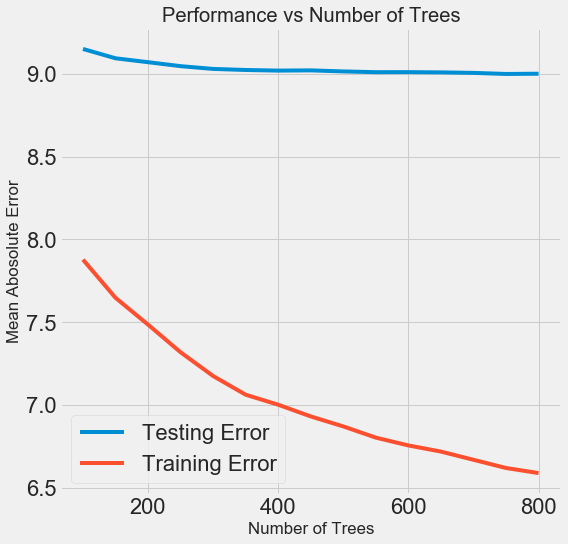

In [27]:
# 将结果导入数据框
results = pd.DataFrame(grid_search.cv_results_)

# 绘制训练误差和测试误差与树木数量的关系图
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [28]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
13,14.369840,0.281917,0.032413,0.004375,750,{'n_estimators': 750},-8.901092,-8.751699,-9.298411,-9.049730,-9.000181,0.201836,1,-6.716494,-6.660453,-6.520818,-6.579989,-6.619438,0.074807
14,14.957021,0.327790,0.030169,0.001295,800,{'n_estimators': 800},-8.903857,-8.758299,-9.296941,-9.047485,-9.001594,0.198793,2,-6.689643,-6.648109,-6.486269,-6.530287,-6.588577,0.083101
12,13.406416,0.316643,0.028174,0.001915,700,{'n_estimators': 700},-8.904269,-8.755862,-9.312990,-9.053755,-9.006666,0.205811,3,-6.743886,-6.695770,-6.611240,-6.624919,-6.668953,0.053861
11,12.764133,0.196318,0.026181,0.000824,650,{'n_estimators': 650},-8.906208,-8.755401,-9.325190,-9.052215,-9.009699,0.210186,4,-6.778068,-6.721452,-6.708191,-6.666758,-6.718617,0.039814
9,10.654021,0.313924,0.029671,0.008415,550,{'n_estimators': 550},-8.918502,-8.756938,-9.325492,-9.042721,-9.010861,0.207970,5,-6.874737,-6.781878,-6.809121,-6.745712,-6.802862,0.047201
